# ShLiDaNa TEXT GENERATOR v1

Create a model that will predict the next word in a text sequence, implementing and training using a corpus of Different datasets, while also creating some helper functions to pre-process the data.

OUR TEAM:

| Name | NIM |
|---|---|
|Shahran Kurnia Ramadhan|21/476650/PA/20592|
|Muhammad Linggar Ryanidha|21/475209/PA/20548|
|Daniel Ardi Chandra|21/479046/PA/20780|
|I Gusti Agung Premananda |21/473829/PA/20432|

In [5]:
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

   # Your code here
   

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17661933985562268098
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9920577536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12228607469402992773
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:09:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [7]:
# Define path for file with datasets
dataset = '..\Datasets\VGCoST_VideoGameDialogue_Corpus\ENG\Portal_merged.txt'

# Read the data
with open(dataset, encoding='ISO-8859-1') as f:
    data = f.read()

# Remove unwanted characters using regex
data = re.sub(r"[\"']", "", data)

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
    print(corpus[i])

There are 5594 lines

The first 5 lines look like this:

@portal, valve, pc, ps3, xbox 360, 2007
@text extracted by ayelis, source: https://www.gamefaqs.com/pc/934386-portal/faqs/50477 (accessed 05/18/2017)

@[cameras]
@[glados says this if you place a portal on the wall under a camera.]


## Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [9]:
corpus[0]

'@portal, valve, pc, ps3, xbox 360, 2007'

If you pass this text directly into the `texts_to_sequences` method you will get an unexpected result:

In [10]:
tokenizer.texts_to_sequences([corpus[0]])

[[69, 1215, 1216, 1487, 1892, 1488, 1489]]

In [11]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[69, 1215, 1216, 1487, 1892, 1488, 1489]

## Generating n_grams

This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus:

In [12]:
# GRADED FUNCTION: n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
	input_sequences = []

	### START CODE HERE

	for line in corpus:
		token_list = tokenizer.texts_to_sequences([line])[0]

		for i in range(1, len(token_list)):
			# Generate subphrase
			n_gram_sequence = token_list[:i+1]
			# Append subphrase to input_sequences list
			input_sequences.append(n_gram_sequence)

	### END CODE HERE

	return input_sequences

In [13]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[69, 1215],
 [69, 1215, 1216],
 [69, 1215, 1216, 1487],
 [69, 1215, 1216, 1487, 1892],
 [69, 1215, 1216, 1487, 1892, 1488],
 [69, 1215, 1216, 1487, 1892, 1488, 1489]]

In [14]:
# Test your function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[1893, 1894],
 [1893, 1894, 87],
 [1893, 1894, 87, 2816],
 [1893, 1894, 87, 2816, 1012],
 [1893, 1894, 87, 2816, 1012, 1895],
 [1893, 1894, 87, 2816, 1012, 1895, 1896],
 [1893, 1894, 87, 2816, 1012, 1895, 1896, 1897],
 [1893, 1894, 87, 2816, 1012, 1895, 1896, 1897, 1490],
 [1893, 1894, 87, 2816, 1012, 1895, 1896, 1897, 1490, 1216],
 [1893, 1894, 87, 2816, 1012, 1895, 1896, 1897, 1490, 1216, 2817],
 [1893, 1894, 87, 2816, 1012, 1895, 1896, 1897, 1490, 1216, 2817, 69],
 [1893, 1894, 87, 2816, 1012, 1895, 1896, 1897, 1490, 1216, 2817, 69, 1898],
 [1893,
  1894,
  87,
  2816,
  1012,
  1895,
  1896,
  1897,
  1490,
  1216,
  2817,
  69,
  1898,
  2818],
 [1893,
  1894,
  87,
  2816,
  1012,
  1895,
  1896,
  1897,
  1490,
  1216,
  2817,
  69,
  1898,
  2818,
  1899],
 [1893,
  1894,
  87,
  2816,
  1012,
  1895,
  1896,
  1897,
  1490,
  1216,
  2817,
  69,
  1898,
  2818,
  1899,
  1491],
 [1893,
  1894,
  87,
  2816,
  1012,
  1895,
  1896,
  1897,
  1490,
  1216,
  2817,
  69,
  1898,

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [15]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 46441
maximum length of sequences is: 21


## Add padding to the sequences

Now code the `pad_seqs` function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences:

In [16]:
# GRADED FUNCTION: pad_seqs
def pad_seqs(input_sequences, maxlen):
    ### START CODE HERE
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')

    return padded_sequences
    ### END CODE HERE

In [17]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, len(first_example_sequence))
first_padded_seq

array([[   0,    0,    0,    0,   69, 1215],
       [   0,    0,    0,   69, 1215, 1216],
       [   0,    0,   69, 1215, 1216, 1487],
       [   0,   69, 1215, 1216, 1487, 1892],
       [  69, 1215, 1216, 1487, 1892, 1488],
       [1215, 1216, 1487, 1892, 1488, 1489]])

In [18]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 1893, 1894],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 1893, 1894,   87],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 1893, 1894,   87, 2816],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 1893, 1894,   87, 2816, 1012],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1893, 1894,   87, 2816, 1012, 1895],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        1893, 1894,   87, 2816, 1012, 1895, 1896],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1893,
        1894,   87, 2816, 1012, 1895, 1896, 1897],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 1893, 1894,
          87, 2816, 1012, 1895, 1896, 1897, 1490],


In [19]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (46441, 21)


## Split the data into features and labels

Before feeding the data into the neural network you should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

In [20]:
# GRADED FUNCTION: features_and_labels
def features_and_labels(input_sequences, total_words):
    ### START CODE HERE
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    ### END CODE HERE

    return features, one_hot_labels

In [21]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (6, 5843)

features look like this:



array([[   0,    0,    0,    0,   69],
       [   0,    0,    0,   69, 1215],
       [   0,    0,   69, 1215, 1216],
       [   0,   69, 1215, 1216, 1487],
       [  69, 1215, 1216, 1487, 1892],
       [1215, 1216, 1487, 1892, 1488]])

In [22]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (46441, 20)
labels have shape: (46441, 5843)


## Create the model

- Should implement Transformer encoder

In [23]:
# GRADED FUNCTION: create_model
def create_model(total_words, max_sequence_len):

    model = Sequential()
    ### START CODE HERE
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [24]:
# Get the untrained model
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

   # Your code here
   
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Train on 46441 samples
Epoch 1/50
46441/46441 [==============================] - 62s 1ms/sample - loss: 6.6903 - accuracy: 0.0501
Epoch 2/50
46441/46441 [==============================] - 61s 1ms/sample - loss: 5.9700 - accuracy: 0.0879
Epoch 3/50
46441/46441 [==============================] - 61s 1ms/sample - loss: 5.4771 - accuracy: 0.1194
Epoch 4/50
46441/46441 [==============================] - 60s 1ms/sample - loss: 5.0549 - accuracy: 0.1436
Epoch 5/50
46441/46441 [==============================] - 59s 1ms/sample - loss: 4.6741 - accuracy: 0.1689
Epoch 6/50
46441/46441 [==============================] - 61s 1ms/sample - loss: 4.3195 - accuracy: 0.1955
Epoch 7/50
46441/46441 [==============================] - 56s 1ms/sample - loss: 3.9791 - accuracy: 0.2316
Epoch 8/50
46441/46441 [==============================] - 51s 1ms/sample - loss: 3.6563 - accuracy: 0.2776
Epoch 9/50
46441/46441 [==============================] - 51s 1ms/sample - loss: 3.3534 - accuracy: 0.3240
Epoch 10/50
46

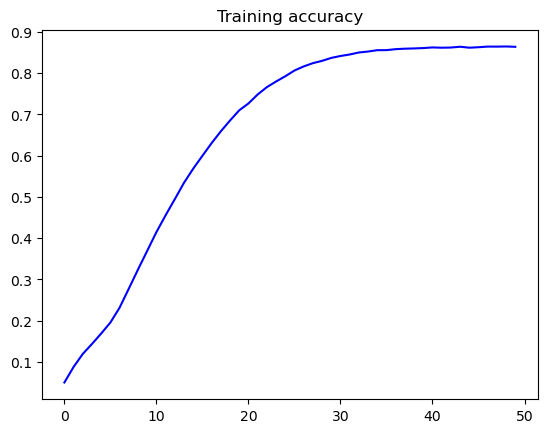

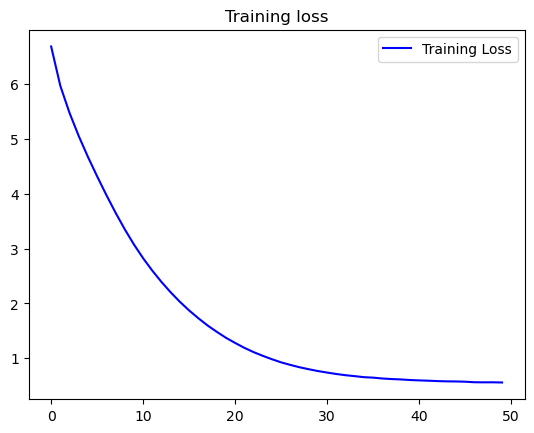

In [25]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

Download the `history.pkl` file which contains the information of the training history of your model and will be used to compute your grade. You can download this file by running the cell below:

In [26]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

ModuleNotFoundError: No module named 'google.colab'

## See our model in action

After all our work it is finally time to see our model generating text.

Run the cell below to generate the next 100 words of a seed text.

In [31]:
seed_text = "Here we are. The Incinerator Room"
next_words = 20

for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Here we are. The Incinerator Room on the robot arm is which we added the other to maps to be a lot of maps to be
